### Анализ данных в задаче кредитного скоринга

In [87]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import scipy
import statsmodels 
from scipy import stats
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
import seaborn as sns
import itertools

Посмотрим на доступные нам данные

In [88]:
df = pd.read_csv('credit_card_default_analysis.csv')

In [89]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Поля в предоставляемых данных имеют следующий смысл: 

LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)

SEX: пол клиента (1 = мужской, 2 = женский )

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

AGE: возраст в годах

PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)

BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 

PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 

default - индикатор невозврата денежных средств

In [90]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверим гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Посмотрим на график распределение суммы кредитного лимита в двух группах

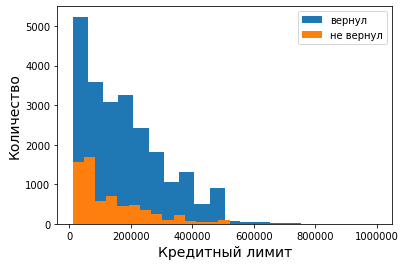

In [91]:
plt.hist(df.loc[df.default == 0, 'LIMIT_BAL'], label = 'вернул', bins = 20)
plt.hist(df.loc[df.default == 1, 'LIMIT_BAL'], label = 'не вернул', bins = 20)
plt.xlabel('Кредитный лимит', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.legend()


Из графиков видно, что признак распределен не нормально. Маленькое значение кредитного лимита более вероятно.
В выборке количество людей вернувших кредит больше чем не вернувших. В целом, распределение в двух группах похожи.

Проверим гипотезу о равенстве медианных значений кредитного лимита у вернувших и не вернувших кредит

$H_0\colon$ Медианные значения равны

$H_1\colon$ Медианные значения различны

Выборки независимые

p-value: 0.05

Проверим гипотезу с помощью интервальной оценки


In [92]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [93]:
credit_return = df.loc[df.default == 0, 'LIMIT_BAL'].values
credit_not_return = df.loc[df.default == 1, 'LIMIT_BAL'].values


credit_return_scores = list(map(np.median, get_bootstrap_samples(credit_return, 1000)))
credit_not_return_scores = list(map(np.median, get_bootstrap_samples(credit_not_return, 1000)))

print("95% доверительный интервал для вернувших кредит:",  stat_intervals(credit_return_scores, 0.05))
print("95% доверительный интервал для не вернувших кредит:",  stat_intervals(credit_not_return_scores, 0.05))

95% доверительный интервал для вернувших кредит: [150000. 150000.]
95% доверительный интервал для не вернувших кредит: [80000. 90000.]


Доверительные интервалы не пересекаются. Можем предположить, что медианные оценки не равны

Выборки имеют очень много повторяющихся значений, поэтому мы не можем использовать критерий Манна-Уитни
Поэтому будем использовать двухвыборочный перестановочный критерий для несвязанных выборок.

In [94]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [95]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [96]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [97]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [98]:
print("p-value: %f" % permutation_test(credit_return, credit_not_return, max_permutations = 5000))

p-value: 0.000200


Нулевая гипотеза отвергается на уровне значимости 0.05.

Медианное значение размера кредитного лимита для тех кто не вернул деньги меньше, чем у тех кто вернул. Можно предположить, что скоринговая система банк работает хорошо и не выдает большие кредиты неподходящим людям. 

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

Посмотрим как распределяются люди по половому признаку среди вернувших кредит 

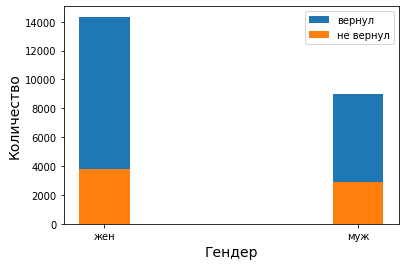

In [99]:
credit_return_s = df.loc[df.default == 0, 'SEX']
credit_not_return_s = df.loc[df.default == 1, 'SEX']
plt.bar(['жен','муж'], credit_return_s.value_counts(), label = 'вернул', width=0.2)
plt.bar(['жен','муж'], credit_not_return_s.value_counts(), label = 'не вернул', width=0.2)
plt.xlabel('Гендер', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.legend()


По графикам можно сделать вывод, что женщины чаще берут кредит и более ответственно относятся к его погашению.

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается при помощи z-критерия для разности долей

$H_0\colon$ доля мужчин и женщин среди вернувших и не вернувших кредит одинаковая.

$H_1\colon$ доля не одинаковая.

Выборки независимые

p-value: 0.05

In [100]:
credit_return_s.replace(2, 0, inplace=True)
credit_not_return_s.replace(2, 0, inplace=True)

In [101]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [102]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(credit_return_s, credit_not_return_s))

confidence interval: [-0.060548, -0.033635]


Доверительный интервал для разности долей не включаетв себя 0, значит гендерный состав группы людей вернувших и не вернувших кредит отличается

Проверим можем ли мы отклонить нулевую гипотезу 

In [103]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [104]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [105]:
print("p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(credit_not_return_s, credit_return_s), 'two-sided'))

p-value:  4.472866521609831e-12


Нулевая гипотеза отвергается на уровне значимости 0.05.
Гендерный состав группы людей вернувших и не вернувших кредит значимо отличаются.
Вряд ли можно говорить о практическом значении, так как доверительный интервал для разности долей узкиий и имеет маленькие значения.


Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг. Составим таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. 

Посмотрим как распределяются люди вернувшие и не вернувшие долг в зависимости от образования

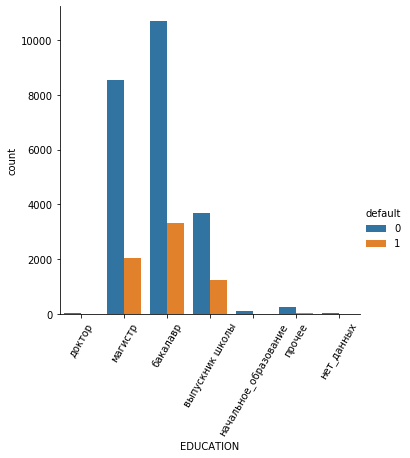

In [106]:
columns = ['доктор', 'магистр','бакалавр', 'выпускник школы', 'начальное_образование','прочее', 'нет_данных']
g = sns.catplot('EDUCATION', data=df, kind='count', hue = "default")
(g.set_xticklabels(columns)
  .set_xticklabels(rotation=60))


График сложно интерпритировать, так как количество людей в каждой категории сильно отличается.

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек кредит. 

$H_0\colon$ Уровень образования и вероятность вернуть кредит не связаны между собой.

$H_1\colon$ Связь есть.

Выборки зависимые

p-value: 0.05

Построим таблицу сопряженности для наблюдаемых значений.

In [107]:
education_return = df.loc[df.default == 0, "EDUCATION"]
education_no_return = df.loc[df.default == 1, "EDUCATION"]
table_observed = pd.DataFrame({'вернул': np.bincount(education_return), 
                               'не_вернул': np.bincount(education_no_return)}).T
table_observed.columns = columns

In [108]:
table_observed

,доктор,магистр,бакалавр,выпускник школы,начальное_образование,прочее,нет_данных
вернул,14,8549,10700,3680,116,262,43
не_вернул,0,2036,3330,1237,7,18,8


Посчитаем меру взаимосвязи между данными с помощью коэффициента V-Крамера. 
Проверим можем ли мы использовать этот метод.

In [109]:
less_5 = 0
for i in table_observed.columns:
    less_5 += (table_observed[i].sum()*table_observed.values[0].sum()/len(df) <= 5)
    less_5 += (table_observed[i].sum()*table_observed.values[1].sum()/len(df) <= 5)
print ('Доля ячеек, где количество элементов меньше 5:', less_5/14)

Доля ячеек, где количество элементов меньше 5: 0.07142857142857142


Условия использования метода выполняются.

In [110]:
def cramers_stat(confusion_matrix):
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

print ('Значение коэффициента V Крамера: ', cramers_stat(table_observed))


Значение коэффициента V Крамера:  0.07376009713252163


Значение не очень большое, но отличное от нуля - значит какая-то зависимость есть. Проверим можно ли отвергнуть нулевую гипотезу.

In [111]:
print ("p-value:", stats.chi2_contingency(table_observed)[1])

p-value: 1.2332626245415605e-32


Нулевая гипотеза отвергается на уровне значимости 0.05.
Зависимость вернет ли чеорвек кредит от степени образования присутствует, но вряд ли имеет какое-то практическое значение, так как коэффициента V Крамера небольшой

Для наглядности построим таблицу сопряженности для разности между наблюдаемым и ожидаемым количеством человек.

In [112]:
table_expected = pd.DataFrame(np.round(stats.chi2_contingency(table_observed)[3]))
table_expected.columns = columns
table_expected.index = ['вернул', 'не_вернул']

In [113]:
table_observed - table_expected

,доктор,магистр,бакалавр,выпускник школы,начальное_образование,прочее,нет_данных
вернул,3.0,305.0,-227.0,-149.0,20.0,44.0,3.0
не_вернул,-3.0,-305.0,227.0,149.0,-20.0,-44.0,-3.0


Из таблицы видно, какие категории людей возвращают кредит чаще, чем можно было бы ожидать. Но значения имеют разный масштаб, поэтому их сложно интерпритировать. 
Для большего понимая разделим каждое значение, на общее количество людей в каждой категории.

In [114]:
table = (table_observed - table_expected) / np.bincount(df.EDUCATION)
table

,доктор,магистр,бакалавр,выпускник школы,начальное_образование,прочее,нет_данных
вернул,0.214286,0.028814,-0.01618,-0.030303,0.162602,0.157143,0.058824
не_вернул,-0.214286,-0.028814,0.01618,0.030303,-0.162602,-0.157143,-0.058824


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

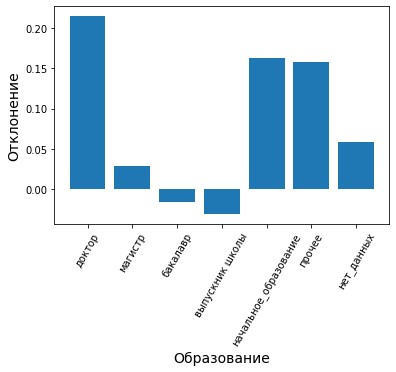

In [115]:
plt.bar(columns, table.values[0])
plt.xlabel('Образование', fontsize=14)
plt.ylabel('Отклонение', fontsize=14)
plt.xticks(rotation=60)

Из графика можно сделать вывод, что люди из категории 'Доктор' чаще возвращают кредит, а 'Выпускники школы' чаще не возвращают.


Проверьте, как связан семейный статус с индикатором дефолта.

Посмотрим как распределяются люди вернувшие и не вернувшие долг в зависимости от семейного положения

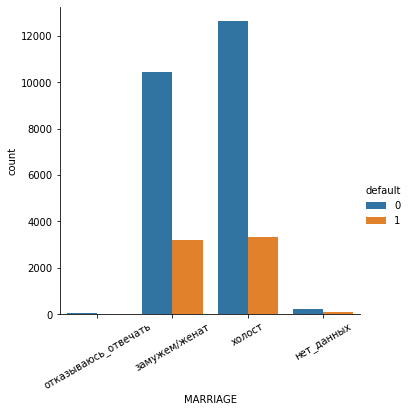

In [116]:
marriage=['отказываюсь_отвечать', 'замужем/женат', 'холост', 'нет_данных']
g = sns.catplot('MARRIAGE', data=df, kind='count', hue = "default")
(g.set_xticklabels(marriage)
  .set_xticklabels(rotation=30))

По графикам можно предположить, что холостые чаще возвращают кредит.
Категории 'Отказываюсь_отвечать' и 'Нет_данных' не особо информативны, так как имеют маленькое количество значений. 

Также посчитаем меру взаимосвязи между данными с помощью коэффициента V-Крамера. 

$H_0\colon$ Зависимости между семейным положением и возвратом кредита нет.

$H_1\colon$ Зависимость есть.

p-value: 0.05

In [117]:
table_marriage = pd.DataFrame({'вернул': np.bincount(marriage_return), 
                               'не_вернул': np.bincount(marriage_no_return)}).T
table_marriage.columns = marriage
table_marriage

,отказываюсь_отвечать,замужем/женат,холост,нет_данных
вернул,49,10453,12623,239
не_вернул,5,3206,3341,84


Проверим можем ли мы использовать этот метод.

In [118]:
less_5 = 0
for i in table_marriage.columns:
    less_5 += table_marriage[i].sum()*table_marriage.values[0].sum()/len(df) <= 5
    less_5 += table_marriage[i].sum()*table_marriage.values[1].sum()/len(df) <= 5
print ('Доля ячеек, где количество элементов меньше 5:', less_5/8)


Доля ячеек, где количество элементов меньше 5: 0.0


Условия использования метода выполняются.

In [119]:
print ('Значение коэффициента V Крамера: ', cramers_stat(table_marriage))
print ("p-value:", stats.chi2_contingency(table_marriage)[1])

Значение коэффициента V Крамера:  0.034478203662766466
p-value: 8.825862457577375e-08


Значение коэффициента V-Крамера не очень большое, но мы можем отвергнуть нулевую гипотезу на уровне значимости 0.05.
Значение признака MARRIAGE влияет на возврат долга, но несущественно.

Относительно двух групп людей вернувших и не вернувших кредит проверим следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Построим графики и посмотрим на распределение признака

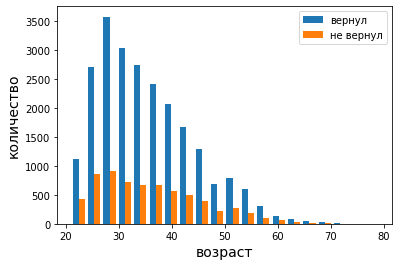

In [120]:
age_return = df.loc[df.default == 0, 'AGE']
age_no_return = df.loc[df.default == 1, 'AGE']
plt.hist([age_return, age_no_return], label = ['вернул', 'не вернул'], bins=20)
plt.xlabel('возраст', fontsize=14)
plt.ylabel('количество', fontsize=14)
plt.legend()

Из графика можно сделать вывод ,что люди в возрасте 25-35 лет чаще берут кредит и чаще его возвращают.
По виду график похож на распределение Пуассона

Провери гипотезу о равенстве медианных значений возрастов людей вернувших и невернувших кредит

$H_0\colon$ Медианные значения равны

$H_1\colon$ Медианные значения отличаются

Выборки несвязанные

p-value: 0.05

Провери гипотезу с помощью интервальной оценки


In [121]:
age_return_scores = list(map(np.median, get_bootstrap_samples(age_return.values, 1000)))
age_not_return_scores = list(map(np.median, get_bootstrap_samples(age_no_return.values, 1000)))

print("95% доверительный интервал для вернувших кредит:",  stat_intervals(age_return_scores, 0.05))
print("95% доверительный интервал для не вернувших кредит:",  stat_intervals(age_not_return_scores, 0.05))

95% доверительный интервал для вернувших кредит: [34. 34.]
95% доверительный интервал для не вернувших кредит: [34. 35.]


Доверительные интервалы пересекаются. Можно предположить, что медианные значения одинаковые

Выборки имеют очень много повторяющихся значений, поэтому мы не можем использовать критерий Манна-Уитни
Поэтому будем использовать двухвыборочный перестановочный критерий для несвязанных выборок.

In [122]:
print("p-value: %f" % permutation_test(age_return.values, age_no_return.values, max_permutations = 1000))


p-value: 0.018000


Нулевая гипотеза отвергается на уровне значимости 0.05.
Вряд ли можно говорить о практической значимости, так как доверительные интервалы обеих выборок очень узкие и пересекаются. 

### Заключение

Все проверенные нами гипотезы умеют небольшое практическое значение. Скорее всего решение о выдаче кредита принимается на основании других данных, например по уровню дохода и информации о прошлых кредитах. 